# Table of contens

1. [Solving Sudoku 2x2 using Grover Algorithm](#sudoku2x2)
    * 1.1 [Approach](#approach)
    * 1.2 [Theory](#theory)
    * 1.3 [Oracle 2x2](#oracle2x2)
    * 1.4 [Amplification for n-qubits](#Amplification)
    * 1.5 [Complete Algorithm](#completealgorithm)
    * 1.6 [Evaluation](#evaluation)
    
2. [Sudoku 3x3](#sudoku3x3)
    * 2.1 [Approach](#approach3x3)
    * 2.2 [Oracle 3x3](#oracle3x3)
    * 2.3 [Complete Algorithm](#completealgorithm3x3)
    * 2.4 [Evaluation](#evaluation3x3)

# 1. Solving Sudoku 2x2 using Grover Algorithm <a class="anchor" id="sudoku2x2"></a>

In [2]:
from qiskit import *
from qiskit.compiler import transpile, assemble 
from qiskit.tools.jupyter import * 
from qiskit.visualization import * 
import math


## 1.1 Approach <a class="anchor" id="approach"></a>

First we are looking at a 2x2 Sudoku with the following numbering 

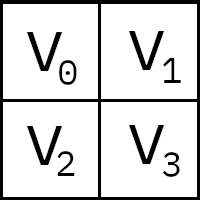
As you see threre a two possible solutions:

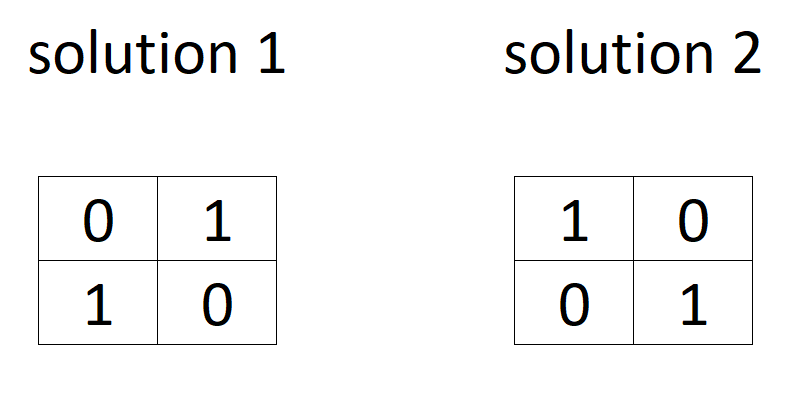

In [22]:
#all these list elements have to be compared to verify the solution
clause_list = [[0,1],[0,2],[1,3],[2,3]]
numbersolutions = 2

In [23]:
var_qubits = QuantumRegister(4, name='v')  # variable qbits
clause_qubits = QuantumRegister(4, name='c') #ancilla qubits
output_qubit = QuantumRegister(1, name='out')#outputqubit

Clause_comparsion = QuantumCircuit(var_qubits,clause_qubits,output_qubit)

#XOR function for every clause
i=0
for clause in clause_list:
    Clause_comparsion.cx(clause,clause_qubits[i])
    i +=1

Clause_comparsion.mct(clause_qubits,output_qubit)
           
Clause_comparsion.draw()



v_0: ──■─────────■────────────────────────────────
         │         │                                
  v_1: ──┼────■────┼─────────■──────────────────────
         │    │    │         │                      
  v_2: ──┼────┼────┼────■────┼─────────■────────────
         │    │    │    │    │         │            
  v_3: ──┼────┼────┼────┼────┼────■────┼────■───────
       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       
  c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──
       └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  
  c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼────■──
                 └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │  
  c_2: ────────────────────┤ X ├┤ X ├──┼────┼────■──
                           └───┘└───┘┌─┴─┐┌─┴─┐  │  
  c_3: ──────────────────────────────┤ X ├┤ X ├──■──
                                     └───┘└───┘┌─┴─┐
out_0: ────────────────────────────────────────┤ X ├
                                               └───┘

## 1.2 Theory<a class="anchor" id="theory"></a>

Why are we doing the previous steps?

To describe the complete circuit we use the following notation.
$|v_0,v_1,v_2,v_3 \rangle |c_0,c_1,c_2,c_3 \rangle |out_0 \rangle = |v \rangle |0\rangle |out\rangle$ 

When using grover you need an Oracle the marks the "winnerstate".

## 1.3 Oracle Sudoku 2x2<a class="anchor" id="oracle2x2"></a>

In [24]:
classicalbits = ClassicalRegister(4, name='classbits')
sudoku = QuantumCircuit(var_qubits, clause_qubits, output_qubit, classicalbits)

#def sudoku_oracle(qc,clause_list,var_qubits, clause_qubits, output_qubit, classicalbits):
i=0
for clause in clause_list:
    #for alpha in range(len(clause_list[i])-1):
    sudoku.cx(clause,clause_qubits[i])
    i +=1
sudoku.barrier()
sudoku.mct(clause_qubits,output_qubit)
sudoku.barrier()
#XOR funciton to get |0000> state for every c_i qubit again
#for more iterations this step is necessary
i=0
for clause in clause_list:
    sudoku.cx(clause,clause_qubits[i])
    i +=1

#sudoku_oracle(sudoku,clause_list,var_qubits, clause_qubits, output_qubit,classicalbits)
sudoku.draw()


░       ░                »
        v_0: ──■─────────■────────────────────────────░───────░───■─────────■──»
               │         │                            ░       ░   │         │  »
        v_1: ──┼────■────┼─────────■──────────────────░───────░───┼────■────┼──»
               │    │    │         │                  ░       ░   │    │    │  »
        v_2: ──┼────┼────┼────■────┼─────────■────────░───────░───┼────┼────┼──»
               │    │    │    │    │         │        ░       ░   │    │    │  »
        v_3: ──┼────┼────┼────┼────┼────■────┼────■───░───────░───┼────┼────┼──»
             ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░       ░ ┌─┴─┐┌─┴─┐  │  »
        c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───░───■───░─┤ X ├┤ X ├──┼──»
             └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   ░   │   ░ └───┘└───┘┌─┴─┐»
        c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼───░───■───░───────────┤ X ├»
                       └───┘└───┘┌─┴─┐┌─┴─┐  │    │   ░   │   ░           └───┘»
        c_2: ────────────────────┤ X ├┤ X ├──┼────┼───░───■───░────────────────»
                                 └───┘└───┘┌─┴─┐┌─┴─┐ ░   │   ░                »
        c_3: ──────────────────────────────┤ X ├┤ X ├─░───■───░────────────────»
                                           └───┘└───┘ ░ ┌─┴─┐ ░                »
      out_0: ─────────────────────────────────────────░─┤ X ├─░────────────────»
                                                      ░ └───┘ ░                »
classbits: 4/══════════════════════════════════════════════════════════════════»
                                                                               »
«                                      
«        v_0: ─────────────────────────
«                                      
«        v_1: ───────■─────────────────
«                    │                 
«        v_2: ──■────┼─────────■───────
«               │    │         │       
«        v_3: ──┼────┼────■────┼────■──
«               │    │    │    │    │  
«        c_0: ──┼────┼────┼────┼────┼──
«             ┌─┴─┐  │    │    │    │  
«        c_1: ┤ X ├──┼────┼────┼────┼──
«             └───┘┌─┴─┐┌─┴─┐  │    │  
«        c_2: ─────┤ X ├┤ X ├──┼────┼──
«                  └───┘└───┘┌─┴─┐┌─┴─┐
«        c_3: ───────────────┤ X ├┤ X ├
«                            └───┘└───┘
«      out_0: ─────────────────────────
«                                      
«classbits: 4/═════════════════════════
«

In [6]:
def sudoku_oracle(qc,clause_list,var_qubits, clause_qubits, output_qubit,classicalbits):
    i=0
    for clause in clause_list:
        qc.cx(clause,clause_qubits[i])
        i +=1
    qc.mct(clause_qubits,output_qubit)
    #XOR funciton to get |0000> state for every c_i qubit again
    #for more iterations this step is necessary
    i=0
    for clause in clause_list:
        qc.cx(clause,clause_qubits[i])
        i +=1
    #U_w = qc.to_gate()
    #U_w.name = "$U_w$"
    #return U_w


## 1.4 Implementation of Amplification circuit for n-qubits<a class="anchor" id="Amplification"></a>

In [7]:
nqubits = 4
qc = QuantumCircuit(nqubits)
#Apply H-Gates to every qubit
for qubit in range(nqubits):
       qc.h(qubit)
# Apply X-gates
for qubit in range(nqubits):
      qc.x(qubit)
#Multi-controlled-Z gate
qc.barrier()
qc.h(nqubits-1)
qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
qc.h(nqubits-1)
qc.barrier()
    # Apply X-gates
for qubit in range(nqubits):
     qc.x(qubit)
#Apply H-Gates to every qubit
for qubit in range(nqubits):
    qc.h(qubit)
qc.draw()

┌───┐┌───┐ ░                 ░ ┌───┐┌───┐
q_0: ┤ H ├┤ X ├─░────────■────────░─┤ X ├┤ H ├
     ├───┤├───┤ ░        │        ░ ├───┤├───┤
q_1: ┤ H ├┤ X ├─░────────■────────░─┤ X ├┤ H ├
     ├───┤├───┤ ░        │        ░ ├───┤├───┤
q_2: ┤ H ├┤ X ├─░────────■────────░─┤ X ├┤ H ├
     ├───┤├───┤ ░ ┌───┐┌─┴─┐┌───┐ ░ ├───┤├───┤
q_3: ┤ H ├┤ X ├─░─┤ H ├┤ X ├┤ H ├─░─┤ X ├┤ H ├
     └───┘└───┘ ░ └───┘└───┘└───┘ ░ └───┘└───┘

In [8]:
def Amplification(nqubits):
    qc = QuantumCircuit(nqubits)
    #Apply H-Gates to every qubit
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply X-gates
    for qubit in range(nqubits):
        qc.x(qubit)
    #Multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply X-gates
    for qubit in range(nqubits):
        qc.x(qubit)
    #Apply H-Gates to every qubit
    for qubit in range(nqubits):
        qc.h(qubit)
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s
testcircuit = QuantumCircuit(4)
testcircuit.append(Amplification(4),[0,1,2,3])
testcircuit.draw()

┌────────┐
q_0: ┤0       ├
     │        │
q_1: ┤1       ├
     │  $U_s$ │
q_2: ┤2       ├
     │        │
q_3: ┤3       ├
     └────────┘

## 1.5 Complete Algorithm 2x2<a class="anchor" id="completealgorithm"></a>

In [25]:
var_qubits = QuantumRegister(4, name='v')  # variable qbits
clause_qubits = QuantumRegister(4, name='c') #ancilla qubits
output_qubit = QuantumRegister(1, name='out')#outputqubit
classicalbits = ClassicalRegister(4, name='classbits')
sudoku = QuantumCircuit(var_qubits, clause_qubits, output_qubit,classicalbits)

#Superpositon state of all var_qubits (equally distributed proabilities)
sudoku.h(var_qubits)

#output_qubit from |0> in state |->
sudoku.x(output_qubit)
sudoku.h(output_qubit)
sudoku.barrier()

#Appyling Oracle and Amplification as often as necessary sqrt(N/M)
for i in range(round(math.sqrt(len(var_qubits)/numbersolutions))+1):
    sudoku_oracle(sudoku,clause_list,var_qubits, clause_qubits, output_qubit,classicalbits)
    #sudoku.append(sudoku_oracle(sudoku,clause_list,var_qubits, clause_qubits, output_qubit),var_qubits,clause_qubits,output_qubit)
    sudoku.append(Amplification(len(var_qubits)),var_qubits)
    sudoku.barrier()

sudoku.measure(var_qubits,classicalbits)
sudoku.draw()

┌───┐      ░                                                   »
        v_0: ┤ H ├──────░───■─────────■──────────────────────────────────■──»
             ├───┤      ░   │         │                                  │  »
        v_1: ┤ H ├──────░───┼────■────┼─────────■────────────────────────┼──»
             ├───┤      ░   │    │    │         │                        │  »
        v_2: ┤ H ├──────░───┼────┼────┼────■────┼─────────■──────────────┼──»
             ├───┤      ░   │    │    │    │    │         │              │  »
        v_3: ┤ H ├──────░───┼────┼────┼────┼────┼────■────┼────■─────────┼──»
             └───┘      ░ ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐»
        c_0: ───────────░─┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├»
                        ░ └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘»
        c_1: ───────────░───────────┤ X ├┤ X ├──┼────┼────┼────┼────■───────»
                        ░           └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │       »
        c_2: ───────────░─────────────────────┤ X ├┤ X ├──┼────┼────■───────»
                        ░                     └───┘└───┘┌─┴─┐┌─┴─┐  │       »
        c_3: ───────────░───────────────────────────────┤ X ├┤ X ├──■───────»
             ┌───┐┌───┐ ░                               └───┘└───┘┌─┴─┐     »
      out_0: ┤ X ├┤ H ├─░─────────────────────────────────────────┤ X ├─────»
             └───┘└───┘ ░                                         └───┘     »
classbits: 4/═══════════════════════════════════════════════════════════════»
                                                                            »
«                                                ┌────────┐ ░                »
«        v_0: ───────■───────────────────────────┤0       ├─░───■─────────■──»
«                    │                           │        │ ░   │         │  »
«        v_1: ──■────┼─────────■─────────────────┤1       ├─░───┼────■────┼──»
«               │    │         │                 │  $U_s$ │ ░   │    │    │  »
«        v_2: ──┼────┼────■────┼─────────■───────┤2       ├─░───┼────┼────┼──»
«               │    │    │    │         │       │        │ ░   │    │    │  »
«        v_3: ──┼────┼────┼────┼────■────┼────■──┤3       ├─░───┼────┼────┼──»
«             ┌─┴─┐  │    │    │    │    │    │  └────────┘ ░ ┌─┴─┐┌─┴─┐  │  »
«        c_0: ┤ X ├──┼────┼────┼────┼────┼────┼─────────────░─┤ X ├┤ X ├──┼──»
«             └───┘┌─┴─┐┌─┴─┐  │    │    │    │             ░ └───┘└───┘┌─┴─┐»
«        c_1: ─────┤ X ├┤ X ├──┼────┼────┼────┼─────────────░───────────┤ X ├»
«                  └───┘└───┘┌─┴─┐┌─┴─┐  │    │             ░           └───┘»
«        c_2: ───────────────┤ X ├┤ X ├──┼────┼─────────────░────────────────»
«                            └───┘└───┘┌─┴─┐┌─┴─┐           ░                »
«        c_3: ─────────────────────────┤ X ├┤ X ├───────────░────────────────»
«                                      └───┘└───┘           ░                »
«      out_0: ──────────────────────────────────────────────░────────────────»
«                                                           ░                »
«classbits: 4/═══════════════════════════════════════════════════════════════»
«                                                                            »
«                                                                              »
«        v_0: ────────────────────────────────■─────────■──────────────────────»
«                                             │         │                      »
«        v_1: ───────■────────────────────────┼────■────┼─────────■────────────»
«                    │                        │    │    │         │            »
«        v_2: ──■────┼─────────■──────────────┼────┼────┼────■────┼─────────■──»
«               │    │         │              │    │    │    │    │         │  »
«        v_3: ──┼────┼────■────┼────■─────────┼────┼────┼────┼────┼────■────┼──»
«               │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │ 

## 1.6 Evaluation<a class="anchor" id="evaluation"></a>

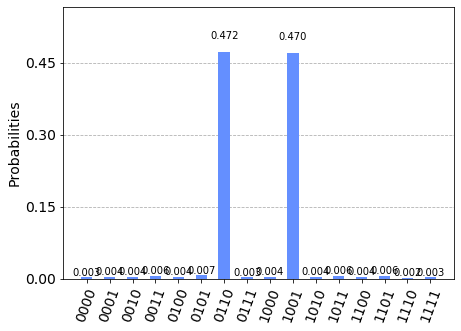

In [10]:
qasm_simulator = Aer.get_backend('qasm_simulator')
result2x2 = execute(sudoku, backend=qasm_simulator, shots=1024).result()
plot_histogram(result2x2.get_counts())
#print(result.get_counts())

# 2. Extending Algorithm to Sudoku with 3x3 Grid<a class="anchor" id="sudoku3x3"></a>

## 2.1 Approach<a class="anchor" id="approach3x3"></a>

In each row and colomn the numbers 0,1,2 are allowed ones. Each number is encoded with two qubits in the binary system.


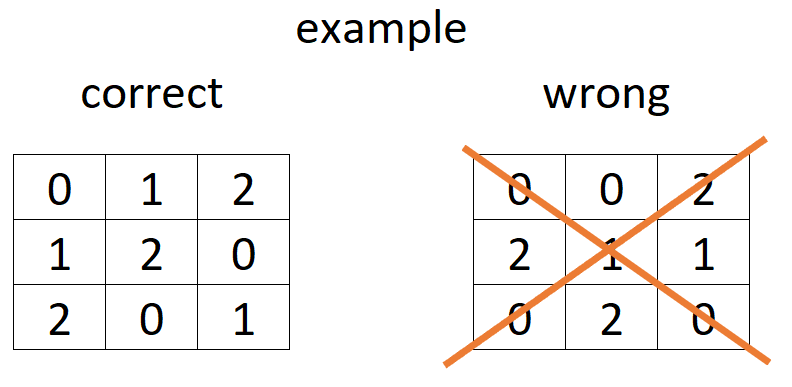


Encoding: 0 $\xrightarrow{}$ 00 , 1 $\xrightarrow{}$ 01 , 2 $\xrightarrow{}$ 10

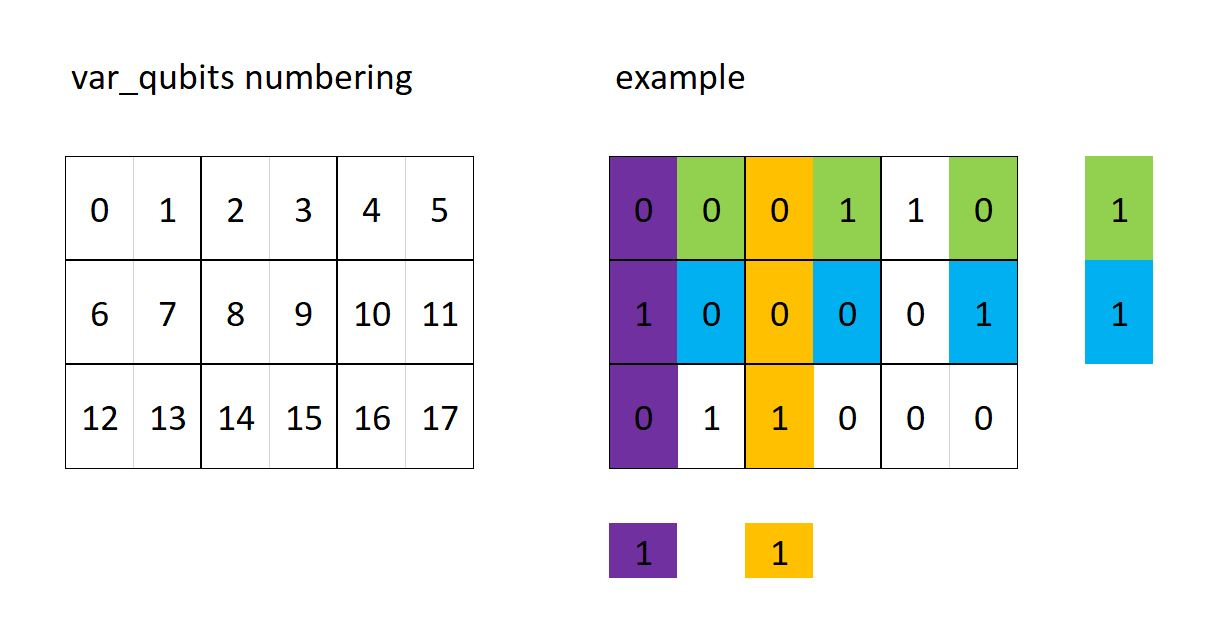



Looking at a possible solution of the 3x3 Sudoku, you recognize that in each row only one 1 is allowed.


In [11]:
clause_list_3x3 = [[0,6,12],[1,7,13],[2,8,14],[3,9,15],[4,10,16],[5,11,17],[0,2,3],[1,3,5],[6,8,10],[7,9,11],[12,14,16],[13,15,17]]

### Test-Gate with test clause_list

In [12]:
# Showing the replacement for the "XOR-Gate" of two qubits now for 3 qubits
clause_list_test = [[0,1,2],[3,4,5]]

test_var_qubits = QuantumRegister(6, name='v')  # variable qbits
test_clause_qubits = QuantumRegister(2, name='c') #ancilla qubits
test_output_qubit = QuantumRegister(1, name='out')#outputqubit
test_classical_qubits = ClassicalRegister(6, name='classical')
qc_test = QuantumCircuit(test_var_qubits,test_clause_qubits,test_output_qubit,test_classical_qubits)

i=0
for clause in clause_list_test:
        qc_test.cx(clause,test_clause_qubits[i])
        qc_test.mct(clause,test_clause_qubits[i])
        i +=1
        
#qc_test.mct(test_clause_qubits,test_output_qubit)

qc_test.draw()


v_0: ──■─────────────────────────────■───────
               │                             │       
        v_1: ──┼─────────■───────────────────■───────
               │         │                   │       
        v_2: ──┼─────────┼─────────■─────────■───────
               │         │         │         │       
        v_3: ──┼────■────┼─────────┼─────────┼────■──
               │    │    │         │         │    │  
        v_4: ──┼────┼────┼────■────┼─────────┼────■──
               │    │    │    │    │         │    │  
        v_5: ──┼────┼────┼────┼────┼────■────┼────■──
             ┌─┴─┐  │  ┌─┴─┐  │  ┌─┴─┐  │  ┌─┴─┐  │  
        c_0: ┤ X ├──┼──┤ X ├──┼──┤ X ├──┼──┤ X ├──┼──
             └───┘┌─┴─┐└───┘┌─┴─┐└───┘┌─┴─┐└───┘┌─┴─┐
        c_1: ─────┤ X ├─────┤ X ├─────┤ X ├─────┤ X ├
                  └───┘     └───┘     └───┘     └───┘
      out_0: ────────────────────────────────────────
                                                     
classical: 6/════════════════════════════════════════

## 2.2 Oracle Algorithm for 3x3 Sudoku<a class="anchor" id="oracle3x3"></a>

In [13]:
#Oracle Algorithm for the 3x3 Sudoku 

var_qubits = QuantumRegister(18, name='v')  # variable qbits
clause_qubits = QuantumRegister(12, name='c') #ancilla qubits
output_qubit = QuantumRegister(1, name='out')#outputqubit
classicalbits = ClassicalRegister(18, name='classbits')
sudoku_orac_3x3 = QuantumCircuit(var_qubits, clause_qubits, output_qubit,classicalbits)

def sudoku_oracle_3x3(qc,clause_list_3x3,var_qubits, clause_qubits, output_qubit,classicalbits):
    i=0
    for clause in clause_list_3x3:
        qc.cx(clause,clause_qubits[i])
        qc.mct(clause,clause_qubits[i])
        i +=1
        
    qc.mct(clause_qubits,output_qubit)
    #XOR funciton to get |0000> state for every c_i qubit again
    #for more iterations this step is necessary
    i=0
    for clause in clause_list_3x3:
        qc.cx(clause,clause_qubits[i])
        qc.mct(clause,clause_qubits[i])
        i +=1
sudoku_oracle_3x3(sudoku_orac_3x3,clause_list_3x3,var_qubits, clause_qubits, output_qubit,classicalbits)
sudoku_orac_3x3.draw()

»
         v_0: ──■──────────────────────────────────────────────────────────────»
                │                                                              »
         v_1: ──┼────■─────────────────────────────────────────────────────────»
                │    │                                                         »
         v_2: ──┼────┼────■────────────────────────────────────────────────────»
                │    │    │                                                    »
         v_3: ──┼────┼────┼────■───────────────────────────────────────────────»
                │    │    │    │                                               »
         v_4: ──┼────┼────┼────┼────■──────────────────────────────────────────»
                │    │    │    │    │                                          »
         v_5: ──┼────┼────┼────┼────┼────■─────────────────────────────────────»
                │    │    │    │    │    │                                     »
         v_6: ──┼────┼────┼────┼────┼────┼────■────────────────────────────────»
                │    │    │    │    │    │    │                                »
         v_7: ──┼────┼────┼────┼────┼────┼────┼────■───────────────────────────»
                │    │    │    │    │    │    │    │                           »
         v_8: ──┼────┼────┼────┼────┼────┼────┼────┼────■──────────────────────»
                │    │    │    │    │    │    │    │    │                      »
         v_9: ──┼────┼────┼────┼────┼────┼────┼────┼────┼────■─────────────────»
                │    │    │    │    │    │    │    │    │    │                 »
        v_10: ──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────■────────────»
                │    │    │    │    │    │    │    │    │    │    │            »
        v_11: ──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────■───────»
                │    │    │    │    │    │    │    │    │    │    │    │       »
        v_12: ──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────■──»
                │    │    │    │    │    │    │    │    │    │    │    │    │  »
        v_13: ──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
                │    │    │    │    │    │    │    │    │    │    │    │    │  »
        v_14: ──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
                │    │    │    │    │    │    │    │    │    │    │    │    │  »
        v_15: ──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
                │    │    │    │    │    │    │    │    │    │    │    │    │  »
        v_16: ──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
                │    │    │    │    │    │    │    │    │    │    │    │    │  »
        v_17: ──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
              ┌─┴─┐  │    │    │    │    │  ┌─┴─┐  │    │    │    │    │  ┌─┴─┐»
         c_0: ┤ X ├──┼────┼────┼────┼────┼──┤ X ├──┼────┼────┼────┼────┼──┤ X ├»
              └───┘┌─┴─┐  │    │    │    │  └───┘┌─┴─┐  │    │    │    │  └───┘»
         c_1: ─────┤ X ├──┼────┼────┼────┼───────┤ X ├──┼────┼────┼────┼───────»
                   └───┘┌─┴─┐  │    │    │       └───┘┌─┴─┐  │    │    │       »
         c_2: ──────────┤ X ├──┼────┼────┼────────────┤ X ├──┼────┼────┼───────»
                        └───┘┌─┴─┐  │    │            └───┘┌─┴─┐  │    │       »
         c_3: ───────────────┤ X ├──┼────┼─────────────────┤ X ├──┼────┼───────»
                             └───┘┌─┴─┐  │                 └───┘┌─┴─┐  │       »
         c_4: ────────────────────┤ X ├──┼──────────────────────┤ X ├──┼───────»
                                  └───┘┌─┴─┐                    └───┘┌─┴─┐     »
         c_5: ─────────────────────────┤ X ├─────────────────────────┤ X ├─────»
                                       └───┘                         └───┘     »
         c_6: ─────────────────────────────────────────────────────────────────»
                             

## 2.3 Complete Algorithm<a class="anchor" id="completealgorithm3x3"></a>

In [14]:
sudoku_3x3 = QuantumCircuit(var_qubits, clause_qubits, output_qubit,classicalbits)

#Superpositon state of all v qubits (equally distributed proabilities)
sudoku_3x3.h(var_qubits)
#output_qubit from |0> in state |->
sudoku_3x3.x(output_qubit)
sudoku_3x3.h(output_qubit)
sudoku_3x3.barrier()

#Appyling Oracle and Amplification as often as necessary
#for i in range(round(math.sqrt(len(var_qubits)/numbersolutions))+1):
sudoku_oracle_3x3(sudoku_3x3,clause_list_3x3,var_qubits, clause_qubits, output_qubit,classicalbits)
    #sudoku.append(sudoku_oracle(sudoku,clause_list,var_qubits, clause_qubits, output_qubit),var_qubits,clause_qubits,output_qubit)
sudoku_3x3.append(Amplification(len(var_qubits)),var_qubits)
sudoku_3x3.barrier()

sudoku_3x3.measure(var_qubits,classicalbits)
sudoku_3x3.draw()

┌───┐      ░                                                   »
         v_0: ┤ H ├──────░───■───────────────────────────────────────────────»
              ├───┤      ░   │                                               »
         v_1: ┤ H ├──────░───┼────■──────────────────────────────────────────»
              ├───┤      ░   │    │                                          »
         v_2: ┤ H ├──────░───┼────┼────■─────────────────────────────────────»
              ├───┤      ░   │    │    │                                     »
         v_3: ┤ H ├──────░───┼────┼────┼────■────────────────────────────────»
              ├───┤      ░   │    │    │    │                                »
         v_4: ┤ H ├──────░───┼────┼────┼────┼────■───────────────────────────»
              ├───┤      ░   │    │    │    │    │                           »
         v_5: ┤ H ├──────░───┼────┼────┼────┼────┼────■──────────────────────»
              ├───┤      ░   │    │    │    │    │    │                      »
         v_6: ┤ H ├──────░───┼────┼────┼────┼────┼────┼────■─────────────────»
              ├───┤      ░   │    │    │    │    │    │    │                 »
         v_7: ┤ H ├──────░───┼────┼────┼────┼────┼────┼────┼────■────────────»
              ├───┤      ░   │    │    │    │    │    │    │    │            »
         v_8: ┤ H ├──────░───┼────┼────┼────┼────┼────┼────┼────┼────■───────»
              ├───┤      ░   │    │    │    │    │    │    │    │    │       »
         v_9: ┤ H ├──────░───┼────┼────┼────┼────┼────┼────┼────┼────┼────■──»
              ├───┤      ░   │    │    │    │    │    │    │    │    │    │  »
        v_10: ┤ H ├──────░───┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
              ├───┤      ░   │    │    │    │    │    │    │    │    │    │  »
        v_11: ┤ H ├──────░───┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
              ├───┤      ░   │    │    │    │    │    │    │    │    │    │  »
        v_12: ┤ H ├──────░───┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
              ├───┤      ░   │    │    │    │    │    │    │    │    │    │  »
        v_13: ┤ H ├──────░───┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
              ├───┤      ░   │    │    │    │    │    │    │    │    │    │  »
        v_14: ┤ H ├──────░───┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
              ├───┤      ░   │    │    │    │    │    │    │    │    │    │  »
        v_15: ┤ H ├──────░───┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
              ├───┤      ░   │    │    │    │    │    │    │    │    │    │  »
        v_16: ┤ H ├──────░───┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
              ├───┤      ░   │    │    │    │    │    │    │    │    │    │  »
        v_17: ┤ H ├──────░───┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
              └───┘      ░ ┌─┴─┐  │    │    │    │    │  ┌─┴─┐  │    │    │  »
         c_0: ───────────░─┤ X ├──┼────┼────┼────┼────┼──┤ X ├──┼────┼────┼──»
                         ░ └───┘┌─┴─┐  │    │    │    │  └───┘┌─┴─┐  │    │  »
         c_1: ───────────░──────┤ X ├──┼────┼────┼────┼───────┤ X ├──┼────┼──»
                         ░      └───┘┌─┴─┐  │    │    │       └───┘┌─┴─┐  │  »
         c_2: ───────────░───────────┤ X ├──┼────┼────┼────────────┤ X ├──┼──»
                         ░           └───┘┌─┴─┐  │    │            └───┘┌─┴─┐»
         c_3: ───────────░────────────────┤ X ├──┼────┼─────────────────┤ X ├»
                         ░                └───┘┌─┴─┐  │                 └───┘»
         c_4: ───────────░─────────────────────┤ X ├──┼──────────────────────»
                         ░                     └───┘┌─┴─┐                    »
         c_5: ───────────░──────────────────────────┤ X ├────────────────────»
                         ░                          └───┘                    »
         c_6: ───────────░───────────────────────────────────────────────────»
                         ░                                      

## 2.4 Evaluation<a class="anchor" id="evaluation3x3"></a>

In [15]:
from qiskit import IBMQ
IBMQ.save_account('b2b6da084e18c57443c774a3c37bad73e3782c0104f9514cf7b1899ecc7831c6b0d77bfcd230e517e4e91feb391e95e86f70e0a4bfe4943c7a029a91bfc5f698')

configrc.store_credentials:WARNING:2020-09-21 16:26:25,020: Credentials already present. Set overwrite=True to overwrite.


In [16]:
#IBMQ.load_account()
#provider = IBMQ.get_provider('ibm-q')
#qcomp = provider.get_backend('ibm_16_melbourne')
#job = execute(sudoku_3x3,backend=qcomp)
#from qiskit.tools.monitor import job_monitor
#job_monitor(job)

IBMQ.load_account()
hub_name = 'ibm-q-education'; group_name = 'tum-filipp-su20'; project_name = 'ph2299'
provider = IBMQ.get_provider(hub=hub_name, group=group_name, project=project_name)
provider.backends()
device = provider.get_backend('ibmq_qasm_simulator')


C:\Users\lukas\Anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [17]:
#ibmq_qasm_simulator = Aer.get_backend('ibmq_qasm_simulator')
#result = execute(sudoku_3x3, backend=ibmq_qasm_simulator, shots=1024).result()
#print(result.get_counts())
#plot_histogram(result.get_counts())

#result = execute(sudoku_orac_3x3,backend = device,shots=100).result()
#print(result.get_counts())

In [18]:
# Showing the replacement for the "XOR-Gate" of two qubits now for 3 qubits
clause_list_test = [[0,1,2],[3,4,5]]

test_var_qubits = QuantumRegister(6, name='v')  # variable qbits
test_clause_qubits = QuantumRegister(2, name='c') #ancilla qubits
test_output_qubit = QuantumRegister(1, name='out')#outputqubit
test_classical_qubits = ClassicalRegister(6, name='classical')
qc_test = QuantumCircuit(test_var_qubits,test_clause_qubits,test_output_qubit,test_classical_qubits)

#Initialize: Superpositon state of all v qubits (equally distributed proabilities)
qc_test.h(test_var_qubits)

#output_qubit from |0> in state |->
qc_test.x(test_output_qubit)
qc_test.h(test_output_qubit)
qc_test.barrier()

numbersolutions_test = 9


for i in range(round(math.sqrt(len(test_var_qubits)/numbersolutions_test))+1):
    #Oracle
    i=0
    for clause in clause_list_test:
            qc_test.cx(clause,test_clause_qubits[i])
            qc_test.mct(clause,test_clause_qubits[i])
            i +=1
        
    qc_test.mct(test_clause_qubits,test_output_qubit)

    i=0
    for clause in clause_list_test:
            qc_test.cx(clause,test_clause_qubits[i])
            qc_test.mct(clause,test_clause_qubits[i])
            i +=1
            
    #Amplification
    qc_test.append(Amplification(len(test_var_qubits)),test_var_qubits)

qc_test.measure(test_var_qubits,test_classical_qubits)
qc_test.draw()

┌───┐      ░                                                   »
        v_0: ┤ H ├──────░───■─────────────────────────────■──────────────■──»
             ├───┤      ░   │                             │              │  »
        v_1: ┤ H ├──────░───┼─────────■───────────────────■──────────────┼──»
             ├───┤      ░   │         │                   │              │  »
        v_2: ┤ H ├──────░───┼─────────┼─────────■─────────■──────────────┼──»
             ├───┤      ░   │         │         │         │              │  »
        v_3: ┤ H ├──────░───┼────■────┼─────────┼─────────┼────■─────────┼──»
             ├───┤      ░   │    │    │         │         │    │         │  »
        v_4: ┤ H ├──────░───┼────┼────┼────■────┼─────────┼────■─────────┼──»
             ├───┤      ░   │    │    │    │    │         │    │         │  »
        v_5: ┤ H ├──────░───┼────┼────┼────┼────┼────■────┼────■─────────┼──»
             └───┘      ░ ┌─┴─┐  │  ┌─┴─┐  │  ┌─┴─┐  │  ┌─┴─┐  │       ┌─┴─┐»
        c_0: ───────────░─┤ X ├──┼──┤ X ├──┼──┤ X ├──┼──┤ X ├──┼────■──┤ X ├»
                        ░ └───┘┌─┴─┐└───┘┌─┴─┐└───┘┌─┴─┐└───┘┌─┴─┐  │  └───┘»
        c_1: ───────────░──────┤ X ├─────┤ X ├─────┤ X ├─────┤ X ├──■───────»
             ┌───┐┌───┐ ░      └───┘     └───┘     └───┘     └───┘┌─┴─┐     »
      out_0: ┤ X ├┤ H ├─░─────────────────────────────────────────┤ X ├─────»
             └───┘└───┘ ░                                         └───┘     »
classical: 6/═══════════════════════════════════════════════════════════════»
                                                                            »
«                                                ┌────────┐                    »
«        v_0: ───────────────────────────■───────┤0       ├──■─────────────────»
«                                        │       │        │  │                 »
«        v_1: ───────■───────────────────■───────┤1       ├──┼─────────■───────»
«                    │                   │       │        │  │         │       »
«        v_2: ───────┼─────────■─────────■───────┤2       ├──┼─────────┼───────»
«                    │         │         │       │  $U_s$ │  │         │       »
«        v_3: ──■────┼─────────┼─────────┼────■──┤3       ├──┼────■────┼───────»
«               │    │         │         │    │  │        │  │    │    │       »
«        v_4: ──┼────┼────■────┼─────────┼────■──┤4       ├──┼────┼────┼────■──»
«               │    │    │    │         │    │  │        │  │    │    │    │  »
«        v_5: ──┼────┼────┼────┼────■────┼────■──┤5       ├──┼────┼────┼────┼──»
«               │  ┌─┴─┐  │  ┌─┴─┐  │  ┌─┴─┐  │  └────────┘┌─┴─┐  │  ┌─┴─┐  │  »
«        c_0: ──┼──┤ X ├──┼──┤ X ├──┼──┤ X ├──┼────────────┤ X ├──┼──┤ X ├──┼──»
«             ┌─┴─┐└───┘┌─┴─┐└───┘┌─┴─┐└───┘┌─┴─┐          └───┘┌─┴─┐└───┘┌─┴─┐»
«        c_1: ┤ X ├─────┤ X ├─────┤ X ├─────┤ X ├───────────────┤ X ├─────┤ X ├»
«             └───┘     └───┘     └───┘     └───┘               └───┘     └───┘»
«      out_0: ─────────────────────────────────────────────────────────────────»
«                                                                              »
«classical: 6/═════════════════════════════════════════════════════════════════»
«                                                                              »
«                                                                              »
«        v_0: ────────────■──────────────■─────────────────────────────■───────»
«                         │              │                             │       »
«        v_1: ────────────■──────────────┼─────────■───────────────────■───────»
«                         │              │         │                   │       »
«        v_2: ──■─────────■──────────────┼─────────┼─────────■─────────■───────»
«               │         │              │         │         │         │       »
«        v_3: ──┼─────────┼────■─────────┼────■────┼─────────┼─────────┼────■──»
«               │         

In [19]:
qasm_simulator = Aer.get_backend('qasm_simulator')
result3x3_test = execute(qc_test, backend=qasm_simulator, shots=1024).result()

counts_dic = result3x3_test.get_counts()

sorted_counts_dic = sorted( counts_dic.items(), key= lambda x : x [1], reverse= True) 
for i in sorted_counts_dic:
    print(i[0],i[1])

100100 122
100001 111
001001 105
001100 101
010010 97
010100 97
100010 90
001010 87
010001 83
111101 8
111000 7
111010 7
010011 5
010110 5
101010 5
111110 5
011000 4
100101 4
110001 4
010111 3
011111 3
100111 3
101101 3
110010 3
110011 3
111001 3
001000 3
000000 2
000001 2
010000 2
011001 2
011100 2
011101 2
000010 2
100000 2
100110 2
101001 2
101110 2
101111 2
110000 2
110100 2
000101 2
000110 2
001011 2
001110 2
001111 2
010101 1
011010 1
011110 1
100011 1
101000 1
101011 1
101100 1
000011 1
110101 1
110110 1
111100 1
111111 1
000100 1
000111 1
001101 1


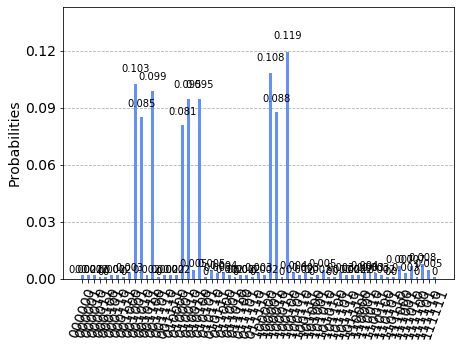

In [20]:
plot_histogram(result3x3_test.get_counts())